In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

In [2]:
x_min, x_max = 0, 2*np.pi   # range of x variable
f = lambda x: np.sin(x)     # true function
sigma_eps = 0.25            # random noise (irreducible)
N = 20             # training set size

def sample_x():
    # Sample N data points uniformly distributed on interval [x_min, x_max]
    return np.random.uniform(x_min, x_max, N)

def sample_xy():
    x = sample_x()
    y = f(x) + np.random.normal(0, sigma_eps, N)
    return x, y

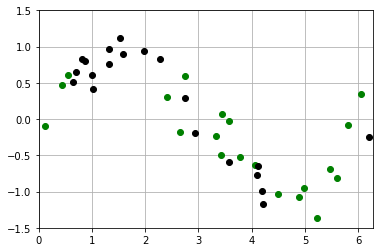

In [3]:
np.random.seed(0)

def plt_new_fig(set_axes = True):
    plt.figure()
    if set_axes:
        y_min, y_max = -1.5, 1.5    # data limits
        # y_min, y_max = -0.5, 1.5    # data limits
        plt.grid()
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

def plot_two_datasets(x1,y1, x2,y2):
    '''Plot two datasets on the same axes and set appropriate limits.'''
    plt_new_fig()
    plt.plot(x1, y1, 'og', x2, y2, 'ok')

x1, y1 = sample_xy()
x2, y2 = sample_xy()

plot_two_datasets(x1,y1, x2,y2)

In [4]:
t = np.linspace(x_min, x_max, 200)   # grid points - locations for plot and numeric integration
degrees_to_display = [0, 1, 3, 9]
warnings.filterwarnings("ignore")    # ingore poorly conditioned warning in polyfit


def fit_and_evaluate_polynomial(x, y, degree, locs = t):
    poly = np.poly1d(np.polyfit(x, y, degree))  # Fit polynomial to data using numpy package
    ploc = poly(locs)                           # Evaluate polynomial at grid points
    return np.clip(ploc, -10, 10)               # for numerical stability


def fit_and_plot_two_datasets(x1,y1, x2,y2, degree):
    fhat_1 = fit_and_evaluate_polynomial(x1, y1, degree)
    fhat_2 = fit_and_evaluate_polynomial(x2, y2, degree)
    
    plt_new_fig()
    plt.plot(x1, y1, 'og', t, fhat_1, '-g',
             x2, y2, 'ok', t, fhat_2, '-k')
    plt.title(f'degree = {degree}')

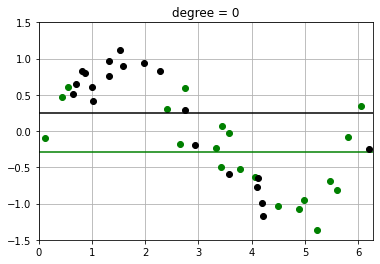

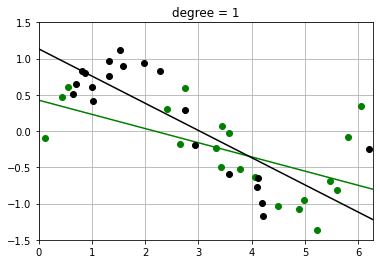

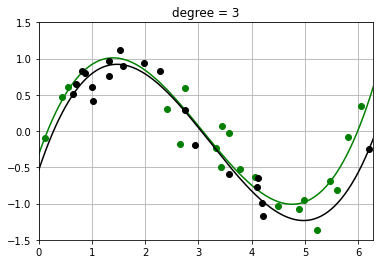

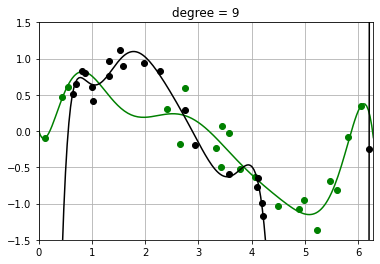

In [5]:
for degree in degrees_to_display:
    fit_and_plot_two_datasets(x1,y1, x2,y2, degree)

In [6]:
def random_fits(degree, num_fits):
    '''Generate random datasets and fit polynomial functions to data.'''
    np.random.seed(0)
    fits = np.zeros((num_fits, len(t)))
    for i in range(num_fits):
        x, y = sample_xy()
        fits[i,:] = fit_and_evaluate_polynomial(x, y, degree)
    return fits

def compute_E_fhat(degree, num_fits = 20000):
    '''Approximate the average fit E[\hat{f}] by averaging over num_fits fits to random datasets.'''
    fits = random_fits(degree, num_fits)
    return fits.mean(axis = 0)

def compute_variance(degree, num_fits = 20000):
    fits = random_fits(degree, num_fits)
    variance_x = fits.var(axis = 0)
    variance_total = variance_x.mean()
    return variance_total

# evaluate E_fhat and variance for each polynomial degree
E_fhat   = {degree: compute_E_fhat(degree)   for degree in degrees_to_display}    
variance = {degree: compute_variance(degree) for degree in degrees_to_display}

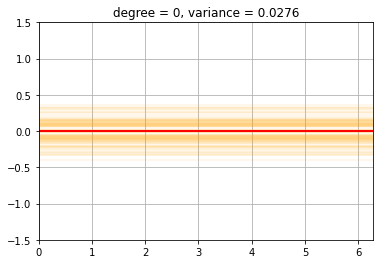

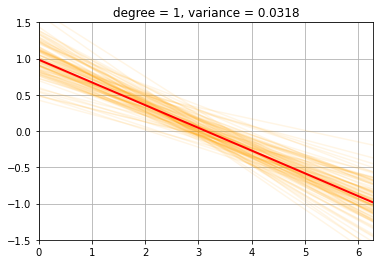

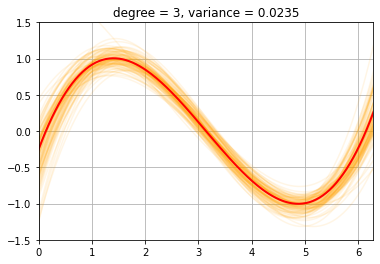

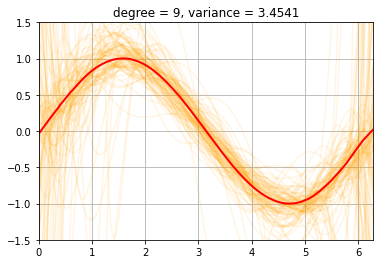

In [7]:
def plot_fits_Efhat(degree):
    fits = random_fits(degree, num_fits = 100)   # Smaller number of fits to speed up plotting
    
    plt_new_fig()
    plt.plot(t, fits.T, color = 'orange', alpha = 0.1);
    plt.plot(t, E_fhat[degree],  color = 'r', linewidth = 2, alpha = 1.0);
    plt.title(f'degree = {degree}, variance = {variance[degree]:.4f}')

for degree in degrees_to_display:
    plot_fits_Efhat(degree);

In [8]:
f_eval = f(t)   # evaluate true function f at grid points

def compute_bias_sq(degree):
    bias_sq_x = np.square(E_fhat[degree] - f_eval)
    bias_sq   = bias_sq_x.mean()  # * t_integral_area
    return bias_sq

bias_sq = {degree: compute_bias_sq(degree) for degree in degrees_to_display}

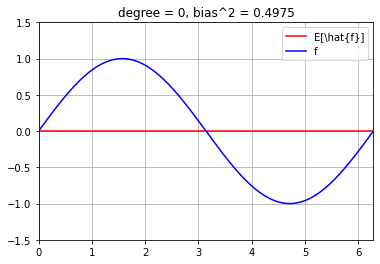

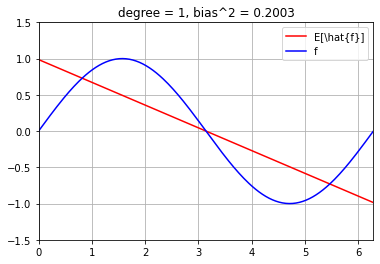

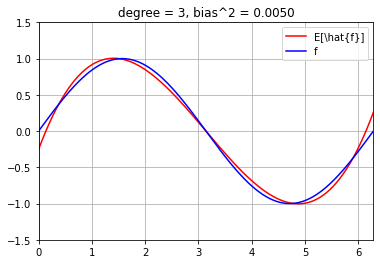

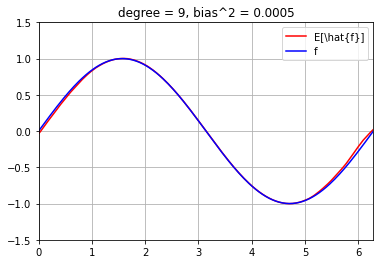

In [9]:
def plot_f_and_E_fhat(degree):
    plt_new_fig()
    plt.plot(t, E_fhat[degree], '-r', t, f_eval, '-b')
    plt.legend(['E[\hat{f}]', 'f'])
    plt.title(f'degree = {degree}, bias^2 = {bias_sq[degree]:.4f}')
    
for degree in degrees_to_display:
    plot_f_and_E_fhat(degree)

,Bias_Sq,Variance,Irreducible,EPE
polynomial degree,,,,
0,0.497500,0.027638,0.0625,0.587638
1,0.200318,0.031793,0.0625,0.294611
3,0.004993,0.023503,0.0625,0.090996
9,0.000483,3.454109,0.0625,3.517092


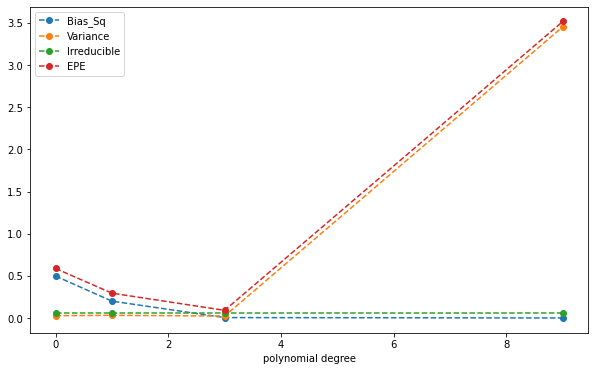

In [10]:
# Put bias, variance, irreducible error into a dataframe for easy display
import pandas as pd
irreducible = {degree: np.square(sigma_eps) for degree in degrees_to_display}
df_EPE = pd.DataFrame({'Bias_Sq': bias_sq, 'Variance': variance, 'Irreducible': irreducible})
df_EPE.index.name = 'polynomial degree'
df_EPE['EPE'] = df_EPE.sum(axis = 1)

display(df_EPE)
df_EPE.plot(linestyle = '--', marker='o', figsize = (10, 6));

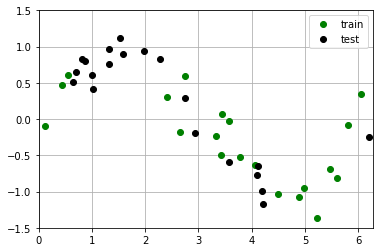

In [11]:
np.random.seed(0)

x_train, y_train = sample_xy()
x_test, y_test   = sample_xy()

plot_two_datasets(x_train, y_train, x_test, y_test)
plt.legend(['train', 'test']);

In [12]:
def fit_and_eval_test_error(degree, x_train, y_train, x_test, y_test):
    y_pred = fit_and_evaluate_polynomial(x_train, y_train, degree,
                                         locs = x_test)
    mean_sq_err = np.square(y_pred - y_test).mean()
    return mean_sq_err

test_error = {degree: fit_and_eval_test_error(degree, x_train, y_train, x_test, y_test)
                      for degree in degrees_to_display}
S = pd.Series(test_error, name = 'test error').to_frame()
S.index.name = 'polynomial degree'

In [13]:
pd.concat([df_EPE['EPE'], S], axis=1)

,EPE,test error
polynomial degree,,
0,0.587638,0.807306
1,0.294611,0.340867
3,0.090996,0.062224
9,3.517092,0.156872


In [14]:
def draw_sample_fit_and_eval_test_error_1(degree):
    '''
    1. Draw a random training and test set
    2. Fit a polynomial of degree degree to the tranining data
    3. Evaluate performance on test set
    '''
    x_train, y_train = sample_xy()
    x_test, y_test   = sample_xy()
    return fit_and_eval_test_error(degree, x_train, y_train, x_test, y_test)

def draw_samples_fit_and_eval_test_error(degree, num_trials = 10000):
    np.random.seed(0)
    test_errors = [draw_sample_fit_and_eval_test_error_1(degree) for _ in range(num_trials)]
    return np.mean(test_errors)

test_errors = {degree: draw_samples_fit_and_eval_test_error(degree)
               for degree in degrees_to_display}
test_errors = pd.Series(test_errors, name = 'test error').to_frame()
test_errors.index.name = 'polynomial degree'

pd.concat([df_EPE['EPE'], test_errors], axis=1)

,EPE,test error
polynomial degree,,
0,0.587638,0.589134
1,0.294611,0.291031
3,0.090996,0.090609
9,3.517092,3.426393
